In [48]:
import math
import sys 
import numpy as np # linear algebra
from scipy.stats import randint
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv), data manipulation as in SQL
import matplotlib.pyplot as plt # this is used for the plot the graph 
import matplotlib.dates as mdates
import seaborn as sns # used for plot interactive graph. 
from sklearn.model_selection import train_test_split # to split the data into two parts
#from sklearn.cross_validation import KFold # use for cross validation
from sklearn.preprocessing import StandardScaler # for normalization
from sklearn.preprocessing import MinMaxScaler
from sklearn.pipeline import Pipeline # pipeline making
from sklearn.model_selection import cross_val_score
from sklearn.feature_selection import SelectFromModel
from sklearn import metrics # for the check the error and accuracy of the model
from sklearn.metrics import mean_squared_error,r2_score
from datetime import timedelta

## for Deep-learing:
import keras
from keras.layers import Dense
from keras.models import Sequential
from keras.utils import to_categorical
from keras.optimizers import SGD 
from keras.callbacks import EarlyStopping
#from keras.utils import np_utils
import itertools
from keras.layers import LSTM
from keras.layers import Conv1D
from keras.layers import MaxPooling1D
from keras.layers import Dropout
from custom_transforms.transforms import *

In [49]:
df = pd.read_csv('../input/teresopolis-2016-2023-precos-medios.csv', sep=',', 
                 parse_dates={'dt' : ['Ano', 'Mês', 'Dia']},
                 low_memory=False, na_values=['nan','?'], index_col='dt')

filtered_alface_crespa_roca = df[df['Produto'] == 'Alface Crespa - Roça'][['Preco_unitario']]
filtered_alface_crespa_roca = filtered_alface_crespa_roca.resample('W').mean()
filtered_alface_crespa_roca = filtered_alface_crespa_roca.interpolate(method='linear')
filtered_alface_crespa_roca.index = filtered_alface_crespa_roca.index.tz_localize("UTC")
filtered_alface_crespa_roca.sort_values(by=['dt'], inplace=True)
filtered_alface_crespa_roca["first_day_week"] = filtered_alface_crespa_roca.index - filtered_alface_crespa_roca.index.weekday * timedelta(days=1)

,Preco_unitario,first_day_week
dt,,
2016-04-24 00:00:00+00:00,0.61650,2016-04-18 00:00:00+00:00
2016-05-01 00:00:00+00:00,0.42611,2016-04-25 00:00:00+00:00
2016-05-08 00:00:00+00:00,0.43778,2016-05-02 00:00:00+00:00
2016-05-15 00:00:00+00:00,0.43056,2016-05-09 00:00:00+00:00
2016-05-22 00:00:00+00:00,0.44444,2016-05-16 00:00:00+00:00
...,...,...
2023-08-27 00:00:00+00:00,0.40833,2023-08-21 00:00:00+00:00
2023-09-03 00:00:00+00:00,0.37500,2023-08-28 00:00:00+00:00
2023-09-10 00:00:00+00:00,0.35417,2023-09-04 00:00:00+00:00


In [50]:
weather_df = pd.read_csv('../processed_data/weather_2016_2023.csv', index_col=0)
weather_df.index = pd.to_datetime(weather_df.index, utc=True)
for col in weather_df.columns:
    weather_df[col] = weather_df[col].replace(-9999, None)
weather_df = weather_df[(weather_df.index >= '2016-04-24') & (weather_df.index <= '2023-09-24')]
weather_weekly_df = pd.DataFrame(weather_df[[ 'PRECIPITAÇÃO TOTAL, HORÁRIO (mm)', 'RADIACAO GLOBAL (Kj/m²)']].resample('W').mean())
weather_weekly_df["first_day_week"] = (weather_weekly_df.index - weather_weekly_df.index.weekday * timedelta(days=1))

In [ ]:
price_weather_df = pd.merge(filtered_alface_crespa_roca, weather_weekly_df, on='first_day_week', how='left')
price_weather_df.index = filtered_alface_crespa_roca.index

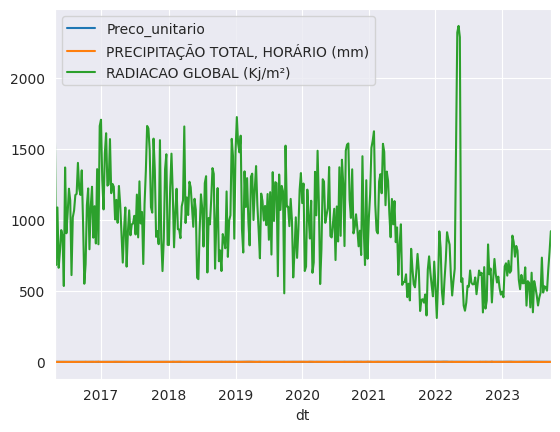

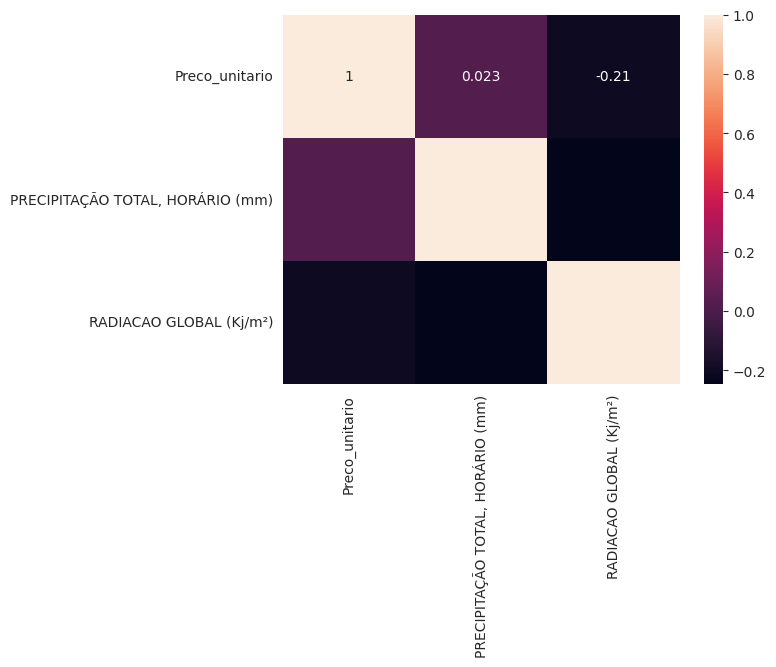

In [54]:

price_weather_df[['Preco_unitario', 'PRECIPITAÇÃO TOTAL, HORÁRIO (mm)', 'RADIACAO GLOBAL (Kj/m²)']].plot()
plt.show()
sns.heatmap(price_weather_df[['Preco_unitario', 'PRECIPITAÇÃO TOTAL, HORÁRIO (mm)', 'RADIACAO GLOBAL (Kj/m²)']].corr(), annot=True)
plt.show()

In [59]:
def input_output_split(data, in_size, out_size):
	#split into input and output
	train_X, train_Y = data.values[:, :-out_size], data.values[:, -out_size:]
	return train_X, train_Y


In [64]:
def train_test_validation_split(data, train_percentage, test_percentage):
	dataset_size = len(data)
	train_size = math.ceil(dataset_size * train_percentage)
	test_size = math.ceil(dataset_size * test_percentage)
	validation_size = dataset_size - train_size - test_size
	print(f"train_size: {train_size}\nvalidation_size: {validation_size}\ntest_size: {test_size}")
	
	train = data[0:train_size]
	validation = data[train_size:train_size + validation_size]
	test = data[train_size + validation_size:dataset_size]
	print(
	f"values_train: {train.shape}\nvalues_validation: {validation.shape}\nvalues_test: {test.shape}")
	#print final percentages
	train_percentage = len(train) / dataset_size
	validation_percentage = len(validation) / dataset_size
	test_percentage = len(test) / dataset_size
	print(f"train_percentage: {train_percentage}\nvalidation_percentage: {validation_percentage}\ntest_percentage: {test_percentage}")
	return train, validation, test


In [65]:
train, valid, test = train_test_validation_split(price_weather_df, 0.7, 0.2)
train_index, valid_index, test_index = train.index, valid.index, test.index

train_size: 272
validation_size: 38
test_size: 78
values_train: (272, 4)
values_validation: (38, 4)
values_test: (78, 4)
train_percentage: 0.7010309278350515
validation_percentage: 0.0979381443298969
test_percentage: 0.20103092783505155


DatetimeIndex(['2022-04-03 00:00:00+00:00', '2022-04-10 00:00:00+00:00',
               '2022-04-17 00:00:00+00:00', '2022-04-24 00:00:00+00:00',
               '2022-05-01 00:00:00+00:00', '2022-05-08 00:00:00+00:00',
               '2022-05-15 00:00:00+00:00', '2022-05-22 00:00:00+00:00',
               '2022-05-29 00:00:00+00:00', '2022-06-05 00:00:00+00:00',
               '2022-06-12 00:00:00+00:00', '2022-06-19 00:00:00+00:00',
               '2022-06-26 00:00:00+00:00', '2022-07-03 00:00:00+00:00',
               '2022-07-10 00:00:00+00:00', '2022-07-17 00:00:00+00:00',
               '2022-07-24 00:00:00+00:00', '2022-07-31 00:00:00+00:00',
               '2022-08-07 00:00:00+00:00', '2022-08-14 00:00:00+00:00',
               '2022-08-21 00:00:00+00:00', '2022-08-28 00:00:00+00:00',
               '2022-09-04 00:00:00+00:00', '2022-09-11 00:00:00+00:00',
               '2022-09-18 00:00:00+00:00', '2022-09-25 00:00:00+00:00',
               '2022-10-02 00:00:00+00:00', '2022-1

In [66]:
in_size = 8
out_size = 8

input_columns = ['Preco_unitario', 'PRECIPITAÇÃO TOTAL, HORÁRIO (mm)']
n_vars = len(input_columns)
scaler = MinMaxScaler(feature_range=(0, 1))
column_selector = ColumnSelector(input_columns) 
reframer = Reframer(n_in=in_size, n_out=out_size)
drop_cols = DropColumns(n_in=in_size, n_out=out_size, n_vars=n_vars)

preprocess_pipeline = Pipeline(
	[
		('column_selector', column_selector),
		('scaler', MinMaxScaler(feature_range=(0, 1))), 
		('reframer', reframer), 
		('drop_cols', drop_cols)
	 ]
)


In [67]:

preprocessed_train = preprocess_pipeline.fit_transform(train)
preprocessed_valid = preprocess_pipeline.transform(valid)
preprocessed_test = preprocess_pipeline.transform(test)

train_X, train_Y = input_output_split(preprocessed_train, in_size, out_size)
validation_X, validation_Y = input_output_split(preprocessed_valid, in_size, out_size)
test_X, test_Y = input_output_split(preprocessed_test, in_size, out_size)

# reshape input to be 3D [samples, timesteps, features]
train_X = train_X.reshape((train_X.shape[0], 1, train_X.shape[1]))
validation_X = validation_X.reshape((validation_X.shape[0], 1, validation_X.shape[1]))
test_X = test_X.reshape((test_X.shape[0], 1, test_X.shape[1]))

print(train_X.shape, train_Y.shape, test_X.shape, test_Y.shape)


(257, 1, 16) (257, 8) (63, 1, 16) (63, 8)


Epoch 1/200
4/4 - 2s - loss: 0.0911 - val_loss: 0.4706 - 2s/epoch - 501ms/step
Epoch 2/200
4/4 - 0s - loss: 0.0653 - val_loss: 0.3881 - 59ms/epoch - 15ms/step
Epoch 3/200
4/4 - 0s - loss: 0.0440 - val_loss: 0.3082 - 59ms/epoch - 15ms/step
Epoch 4/200
4/4 - 0s - loss: 0.0305 - val_loss: 0.2404 - 60ms/epoch - 15ms/step
Epoch 5/200
4/4 - 0s - loss: 0.0273 - val_loss: 0.2001 - 66ms/epoch - 17ms/step
Epoch 6/200
4/4 - 0s - loss: 0.0298 - val_loss: 0.1908 - 66ms/epoch - 16ms/step
Epoch 7/200
4/4 - 0s - loss: 0.0296 - val_loss: 0.2020 - 65ms/epoch - 16ms/step
Epoch 8/200
4/4 - 0s - loss: 0.0275 - val_loss: 0.2222 - 67ms/epoch - 17ms/step
Epoch 9/200
4/4 - 0s - loss: 0.0250 - val_loss: 0.2409 - 64ms/epoch - 16ms/step
Epoch 10/200
4/4 - 0s - loss: 0.0249 - val_loss: 0.2512 - 69ms/epoch - 17ms/step
Epoch 11/200
4/4 - 0s - loss: 0.0245 - val_loss: 0.2517 - 66ms/epoch - 17ms/step
Epoch 12/200
4/4 - 0s - loss: 0.0241 - val_loss: 0.2459 - 66ms/epoch - 17ms/step
Epoch 13/200
4/4 - 0s - loss: 0.0233 -

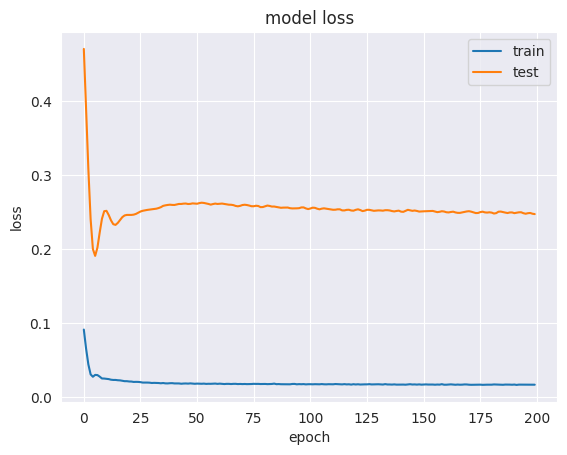

In [68]:

model = Sequential()
model.add(LSTM(400, input_shape=(train_X.shape[1], train_X.shape[2])))
model.add(Dropout(0.2))
model.add(Dense(out_size))
model.compile(loss='mean_squared_error', optimizer='adam')

# fit network
history = model.fit(train_X, train_Y, epochs=200, batch_size=70, validation_data=(validation_X, validation_Y), verbose=2, shuffle=False)

# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper right')
plt.show()

In [69]:
# make a prediction
yhat = model.predict(test_X)
#test_X = test_X.reshape((test_X.shape[0], 16))
# calculate RMSE
rmse = np.sqrt(mean_squared_error(test_Y, yhat))
print('Test RMSE: %.3f' % rmse)

2/2 [==============================] - 0s 3ms/step
Test RMSE: 0.424


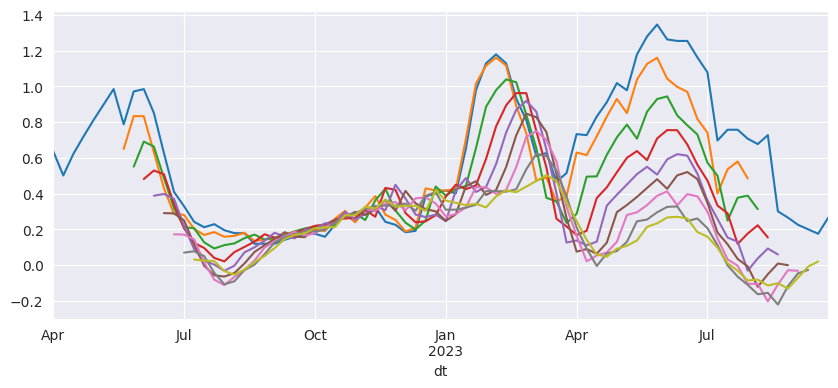

In [70]:
test_price = preprocess_pipeline[:-2].transform(test)[:,0]
test_series = pd.Series(test_price, index=test_index)
pred_0 = pd.Series(yhat[:,0], index=test_index[7:len(yhat)+7])
pred_1 = pd.Series(yhat[:,1], index=test_index[8:len(yhat)+8])
pred_2 = pd.Series(yhat[:,2], index=test_index[9:len(yhat)+9])
pred_3 = pd.Series(yhat[:,3], index=test_index[10:len(yhat)+10])
pred_4 = pd.Series(yhat[:,4], index=test_index[11:len(yhat)+11])
pred_5 = pd.Series(yhat[:,5], index=test_index[12:len(yhat)+12])
pred_6 = pd.Series(yhat[:,6], index=test_index[13:len(yhat)+13])
pred_7 = pd.Series(yhat[:,7], index=test_index[14:len(yhat)+14])

plt.figure(figsize=(10, 4))
test_series.plot()
pred_0.plot()
pred_1.plot()
pred_2.plot()
pred_3.plot()
pred_4.plot()
pred_5.plot()
pred_6.plot()
pred_7.plot()
plt.show()

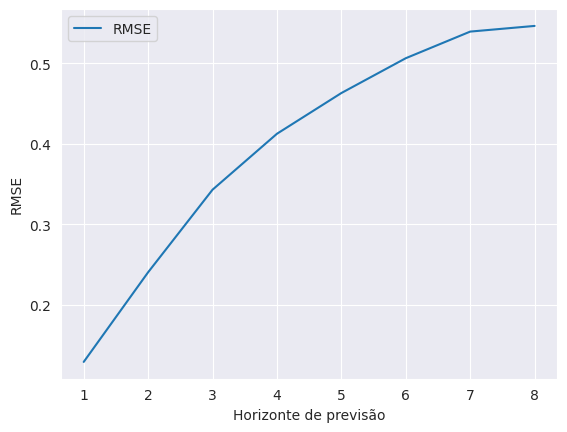

In [71]:

rmse_by_distance = [np.sqrt(mean_squared_error(test_series[7:len(pred_0)+7], pred_0)),
					np.sqrt(mean_squared_error(test_series[8:len(pred_1)+8], pred_1)),
					np.sqrt(mean_squared_error(test_series[9:len(pred_2)+9], pred_2)),
					np.sqrt(mean_squared_error(test_series[10:len(pred_3)+10], pred_3)),
					np.sqrt(mean_squared_error(test_series[11:len(pred_4)+11], pred_4)),
					np.sqrt(mean_squared_error(test_series[12:len(pred_5)+12], pred_5)),
					np.sqrt(mean_squared_error(test_series[13:len(pred_6)+13], pred_6)),
					np.sqrt(mean_squared_error(test_series[14:len(pred_7)+14], pred_7))]
rmses = pd.DataFrame(rmse_by_distance, index=[i+1 for i in range(8)], columns=['RMSE'])
rmses.plot()
plt.xlabel('Horizonte de previsão')
plt.ylabel('RMSE')
plt.show()
#pd.Series(test_Y[:,0]).plot()

In [111]:
# invert scaling for forecast
inv_yhat = np.concatenate((yhat, test_X[:, -1:]), axis=1)
inv_yhat = scaler.inverse_transform(inv_yhat)
inv_yhat = inv_yhat[:,0]

# invert scaling for actual
test_Y = test_Y.reshape((len(test_Y), 1))
inv_y = np.concatenate((test_Y, test_X[:, -1:]), axis=1)
inv_y = scaler.inverse_transform(inv_y)
inv_y = inv_y[:,0]

# calculate RMSE
rmse = np.sqrt(mean_squared_error(inv_y, inv_yhat))
print('Test RMSE: %.3f' % rmse)
comparison_df = pd.DataFrame({'actual': inv_y, 'predicted': inv_yhat}, index=price_weather_df.index[train_size+validation_size:243])
comparison_df.plot()

ValueError: all the input arrays must have same number of dimensions, but the array at index 0 has 2 dimension(s) and the array at index 1 has 3 dimension(s)

In [ ]:
#X = test_X[0, :].reshape((1, 1, test_X.shape[2]))
#next_y = model.predict(X)
#yhat = [next_y]

#for i in range(len(test_Y)-1):
#	X = np.concatenate((X[:, :, 1:], next_y.reshape((1, 1, 1))), axis=2)
#	next_y = model.predict(X)
#	yhat.append(next_y)

#yhat = np.array(yhat).reshape((len(yhat), 1))
#test_X = test_X.reshape((test_X.shape[0], 4))

# invert scaling for forecast
#inv_yhat = np.concatenate((yhat, test_X[:, -1:]), axis=1)
#inv_yhat = scaler.inverse_transform(inv_yhat)
#inv_yhat = inv_yhat[:,0]

# invert scaling for actual
#test_Y = test_Y.reshape((len(test_Y), 1))
#inv_y = np.concatenate((test_Y, test_X[:, -1:]), axis=1)
#inv_y = scaler.inverse_transform(inv_y)
#inv_y = inv_y[:,0]

# calculate RMSE
#rmse = np.sqrt(mean_squared_error(inv_y, inv_yhat))
#print('Test RMSE: %.3f' % rmse)
#comparison_df = pd.DataFrame({'actual': inv_y, 'predicted': inv_yhat}, index=price_weather_df.index[train_size+validation_size:243])
#comparison_df.plot()